In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns

column_names = [
    'date',
    'street',
    'direction',
    'location',
    'type',    
    'accidentTime',
    'interventionTime',
    'extra_delimiter_col'
]

df = pd.read_csv('data.csv', delimiter=';', names=column_names, skiprows=1)

#### Data Cleaning
In this step, we will clean the data and remove unnecessary records. Vehicle breakdown records will be removed, keeping only accident data. Records with NaN values will be deleted. Additionally, unused columns will also be removed.


In [46]:
# Clean NaN values - removes rows that contain any missing (NaN) values
print(f"Total number of records: {len(df)}")
df = df.dropna(subset=['date', 'street', 'direction', 'type'])
print(f"Number of records after removing NaN values: {len(df)}")

# Select only the columns we need for analysis
df = df[['date', 'street', 'direction', 'type']]

# Filter out breakdown records and other unwanted types
breakdown_types = ['Arızalı', 'Yakıt Bitimi', 'Adli Vaka', 'Patlak Lastik', 'Heyelan', 'Bekleme',
                   'Asfalt Çalışması', 'İzsu Çalışması', 'Uygulama', 'Yoğun Duman', 'Perdeleme',
                   'Ağır Vasıta', 'Yol Yapım', 'Futbol Maçı','Aşan Yükseklik', 'Yaya Yolu Çalışması', 'Yangın', 'Yakıtı Biten']
df = df[~df['type'].isin(breakdown_types)]
print(f"Number of records after removing breakdown records: {len(df)}")

# Convert date format from MM/D/YY to DD.MM.YYYY
def convert_date_format(date_str):
    if '/' in date_str:
        # Handle MM/D/YY format
        parts = date_str.split('/')
        month = parts[0].zfill(2)  # Add leading zero if needed
        day = parts[1].zfill(2)    # Add leading zero if needed
        year = '20' + parts[2]     # Convert YY to YYYY
        return f"{day}.{month}.{year}"
    else:
        # Already in DD.MM.YYYY format
        return date_str

df['date'] = df['date'].apply(convert_date_format)
print(f"Date format converted to DD.MM.YYYY")

# Split date column and add month and year columns
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Select only the columns we need for analysis
df = df[['month', 'year', 'street', 'direction']]

# Remove 2021 data
print(f"Number of records before removing 2021 data: {len(df)}")
df = df[df['year'] != 2021]
print(f"Number of records after removing 2021 data: {len(df)}")


# Display the first 5 records
print("\nFirst 5 records after data cleaning:")
print(df.head())

Total number of records: 21107
Number of records after removing NaN values: 21091
Number of records after removing breakdown records: 13341
Date format converted to DD.MM.YYYY
Number of records before removing 2021 data: 13341
Number of records after removing 2021 data: 13047

First 5 records after data cleaning:
    month  year                        street     direction
11      1  2022                 Erdem Caddesi      Şirinyer
12      4  2022      Halil Rıfat Paşa Caddesi  Konak Tüneli
13      5  2022           Hacılarkırı Caddesi     5. Sanayi
18      1  2022  Nursultan Nazarbayev Caddesi     Karşıyaka
21      1  2022             Fevzipaşa Bulvarı       Basmane


#### Monthly Accident Analysis

In this section, we analyze the monthly distribution of traffic accidents by year. The line chart below shows how monthly accident counts change for each year. Each year is represented by a different line, allowing us to easily observe seasonal trends and make year-to-year comparisons.



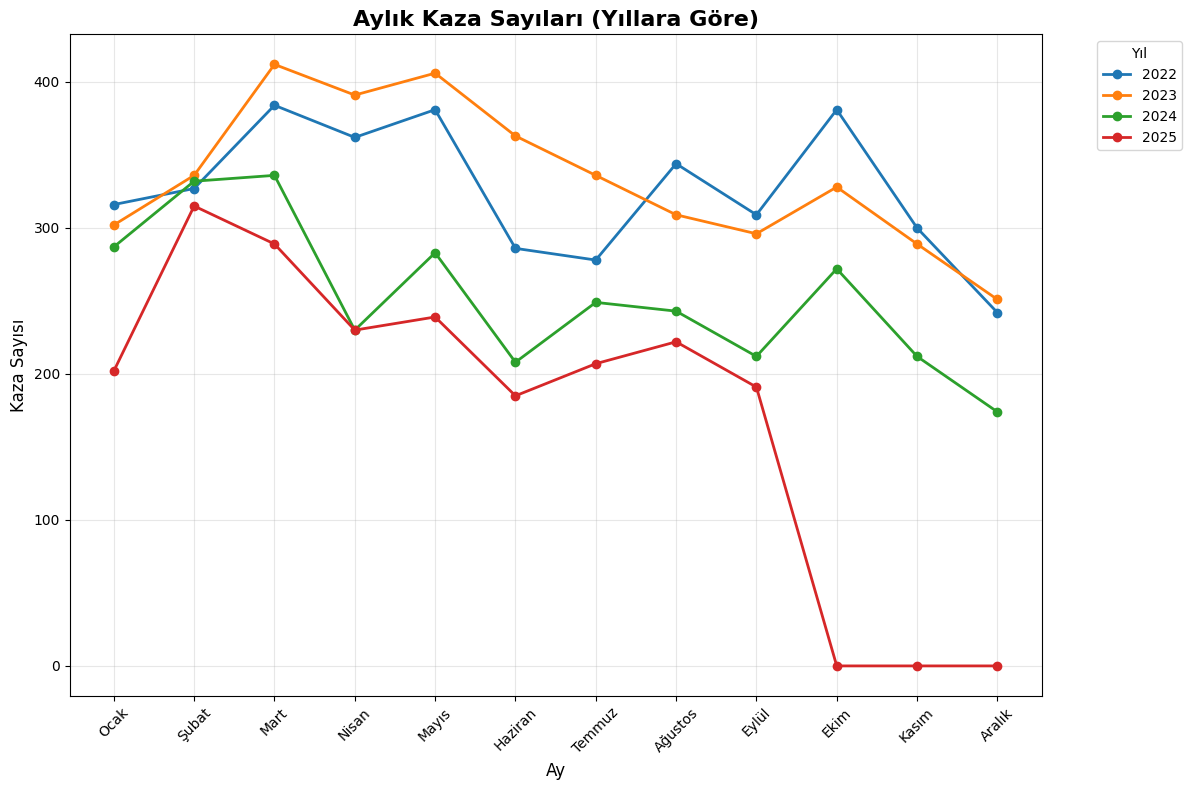


Aylık kaza sayıları özeti:
year    2022   2023   2024   2025
month                            
1      316.0  302.0  287.0  202.0
2      327.0  336.0  332.0  315.0
3      384.0  412.0  336.0  289.0
4      362.0  391.0  230.0  230.0
5      381.0  406.0  283.0  239.0
6      286.0  363.0  208.0  185.0
7      278.0  336.0  249.0  207.0
8      344.0  309.0  243.0  222.0
9      309.0  296.0  212.0  191.0
10     381.0  328.0  272.0    0.0
11     300.0  289.0  212.0    0.0
12     242.0  251.0  174.0    0.0


In [47]:
# Create monthly accident counts by year
monthly_accidents = df_filtered.groupby(['year', 'month']).size().reset_index(name='accident_count')

# Create a pivot table for easier plotting
pivot_data = monthly_accidents.pivot(index='month', columns='year', values='accident_count').fillna(0)

# Create the line plot
plt.figure(figsize=(12, 8))

# Plot a line for each year
for year in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[year], marker='o', linewidth=2, label=f'{int(year)}')

plt.title('Aylık Kaza Sayıları (Yıllara Göre)', fontsize=16, fontweight='bold')
plt.xlabel('Ay', fontsize=12)
plt.ylabel('Kaza Sayısı', fontsize=12)
plt.legend(title='Yıl', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13), ['Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran', 
                          'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık'], rotation=45)
plt.tight_layout()
plt.show()

# Display summary statistics
print("\nAylık kaza sayıları özeti:")
print(pivot_data)

#### Top 10 Accident-Prone Areas by Year

In this section, we analyze the top 10 areas with the highest number of traffic accidents for each year. The chart below shows which locations are the most accident-prone by year, helping us track changes in traffic safety patterns and identify consistently high-risk areas over time.

In [48]:
def plot_top_accident_areas_by_year(year, top_n=10):
    # Filter data by year
    year_data = df_filtered[df_filtered['year'] == year]

    # Group by street and direction, then count accidents
    area_accidents = year_data.groupby(['street', 'direction']).size().reset_index(name='accident_count')
    
    # Create combined street-direction column
    area_accidents['street_direction'] = area_accidents['street'] + ' - ' + area_accidents['direction']
    
    # Get top N areas
    top_areas = area_accidents.nlargest(top_n, 'accident_count')
    
    # Create bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(top_areas)), top_areas['accident_count'], color='steelblue', alpha=0.7)
    
    plt.title(f'{year} Yılı En Fazla Kaza Olan {top_n} Bölge (Cadde-Yön)', fontsize=16, fontweight='bold')
    plt.xlabel('Bölge (Cadde-Yön)', fontsize=12)
    plt.ylabel('Kaza Sayısı', fontsize=12)
    plt.xticks(range(len(top_areas)), top_areas['street_direction'], rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print top areas
    print(f"\n{year} yılı en fazla kaza olan {top_n} bölge:")
    for i, row in top_areas.iterrows():
        print(f"{row['street_direction']}: {row['accident_count']} kaza")

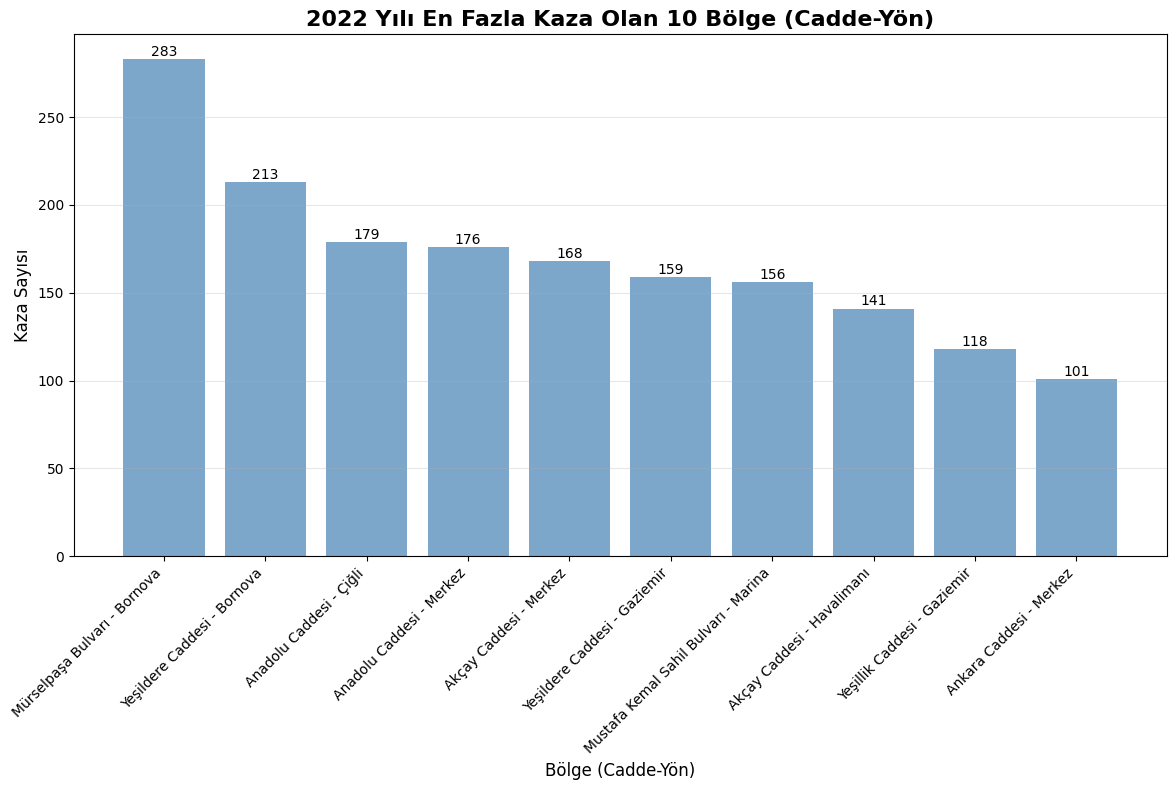


2022 yılı en fazla kaza olan 10 bölge:
Mürselpaşa Bulvarı - Bornova: 283 kaza
Yeşildere Caddesi - Bornova: 213 kaza
Anadolu Caddesi - Çiğli: 179 kaza
Anadolu Caddesi - Merkez: 176 kaza
Akçay Caddesi - Merkez: 168 kaza
Yeşildere Caddesi - Gaziemir: 159 kaza
Mustafa Kemal Sahil Bulvarı - Marina: 156 kaza
Akçay Caddesi - Havalimanı: 141 kaza
Yeşillik Caddesi - Gaziemir: 118 kaza
Ankara Caddesi - Merkez: 101 kaza


In [49]:
# Plot top accident areas for 2022
plot_top_accident_areas_by_year(2022)

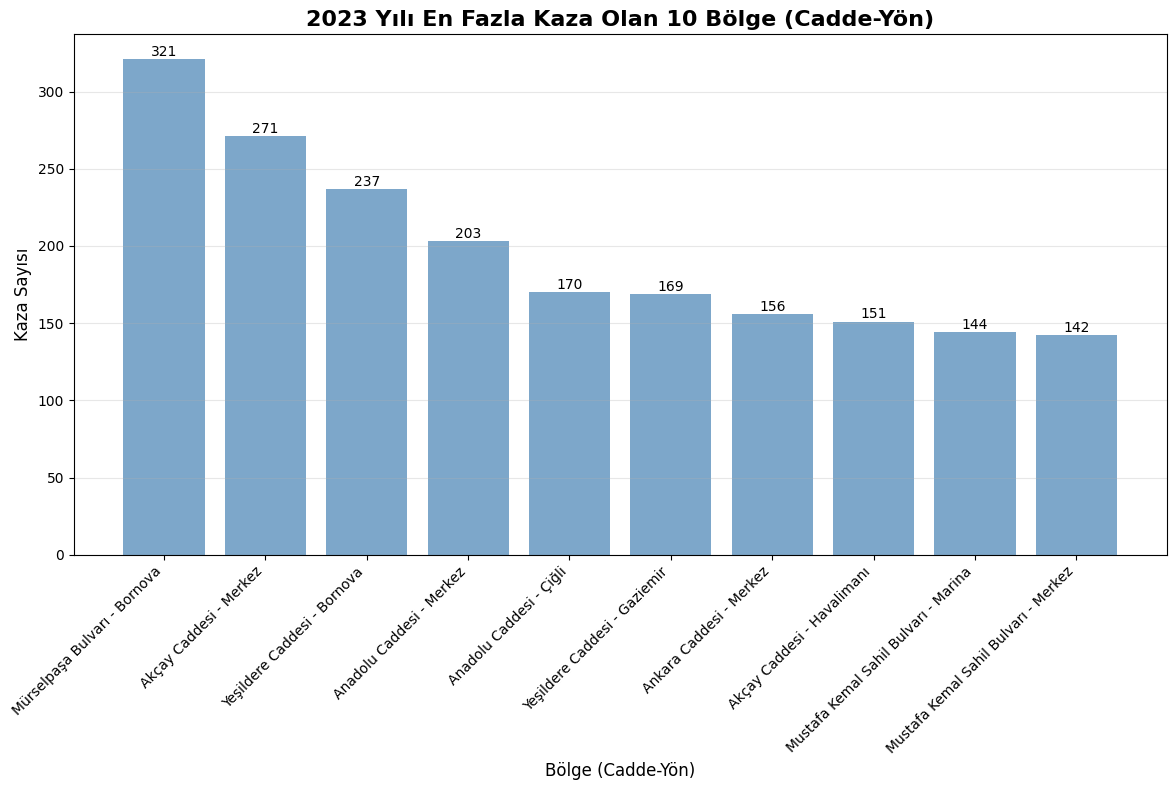


2023 yılı en fazla kaza olan 10 bölge:
Mürselpaşa Bulvarı - Bornova: 321 kaza
Akçay Caddesi - Merkez: 271 kaza
Yeşildere Caddesi - Bornova: 237 kaza
Anadolu Caddesi - Merkez: 203 kaza
Anadolu Caddesi - Çiğli: 170 kaza
Yeşildere Caddesi - Gaziemir: 169 kaza
Ankara Caddesi - Merkez: 156 kaza
Akçay Caddesi - Havalimanı: 151 kaza
Mustafa Kemal Sahil Bulvarı - Marina: 144 kaza
Mustafa Kemal Sahil Bulvarı - Merkez: 142 kaza


In [50]:
# Plot top accident areas for 2023
plot_top_accident_areas_by_year(2023)

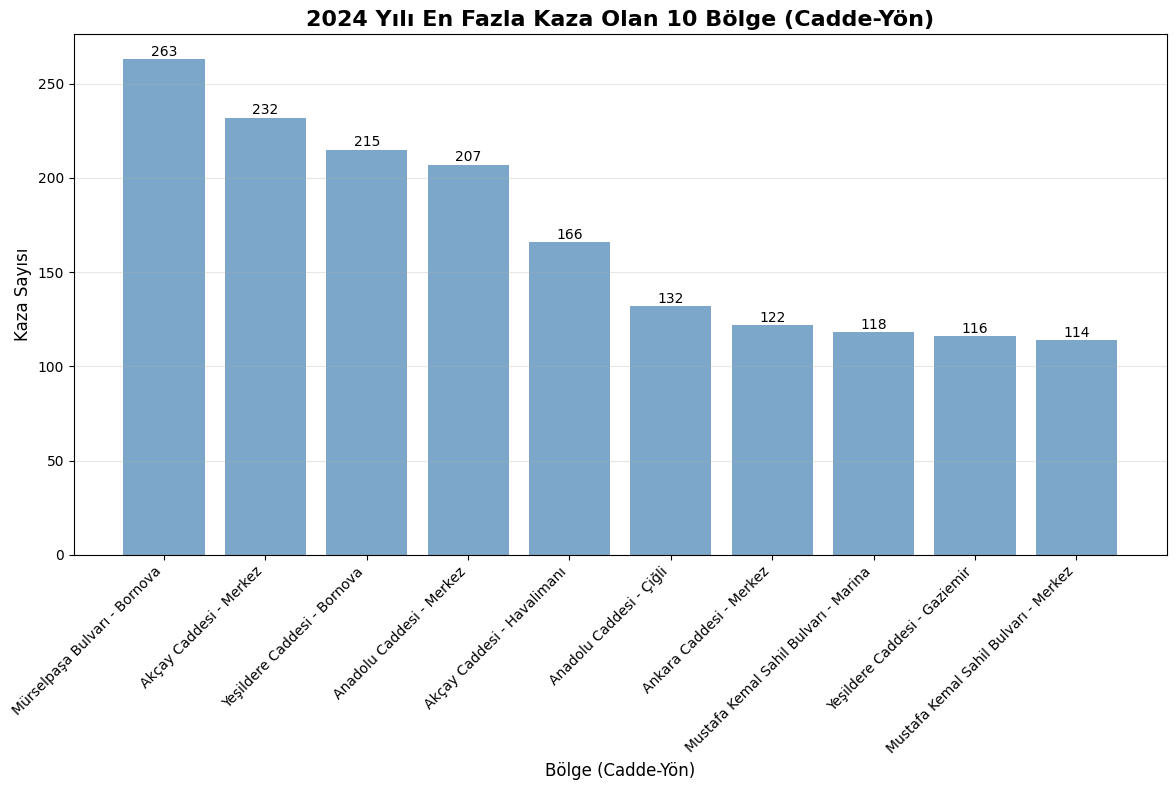


2024 yılı en fazla kaza olan 10 bölge:
Mürselpaşa Bulvarı - Bornova: 263 kaza
Akçay Caddesi - Merkez: 232 kaza
Yeşildere Caddesi - Bornova: 215 kaza
Anadolu Caddesi - Merkez: 207 kaza
Akçay Caddesi - Havalimanı: 166 kaza
Anadolu Caddesi - Çiğli: 132 kaza
Ankara Caddesi - Merkez: 122 kaza
Mustafa Kemal Sahil Bulvarı - Marina: 118 kaza
Yeşildere Caddesi - Gaziemir: 116 kaza
Mustafa Kemal Sahil Bulvarı - Merkez: 114 kaza


In [51]:
# Plot top accident areas for 2024
plot_top_accident_areas_by_year(2024)


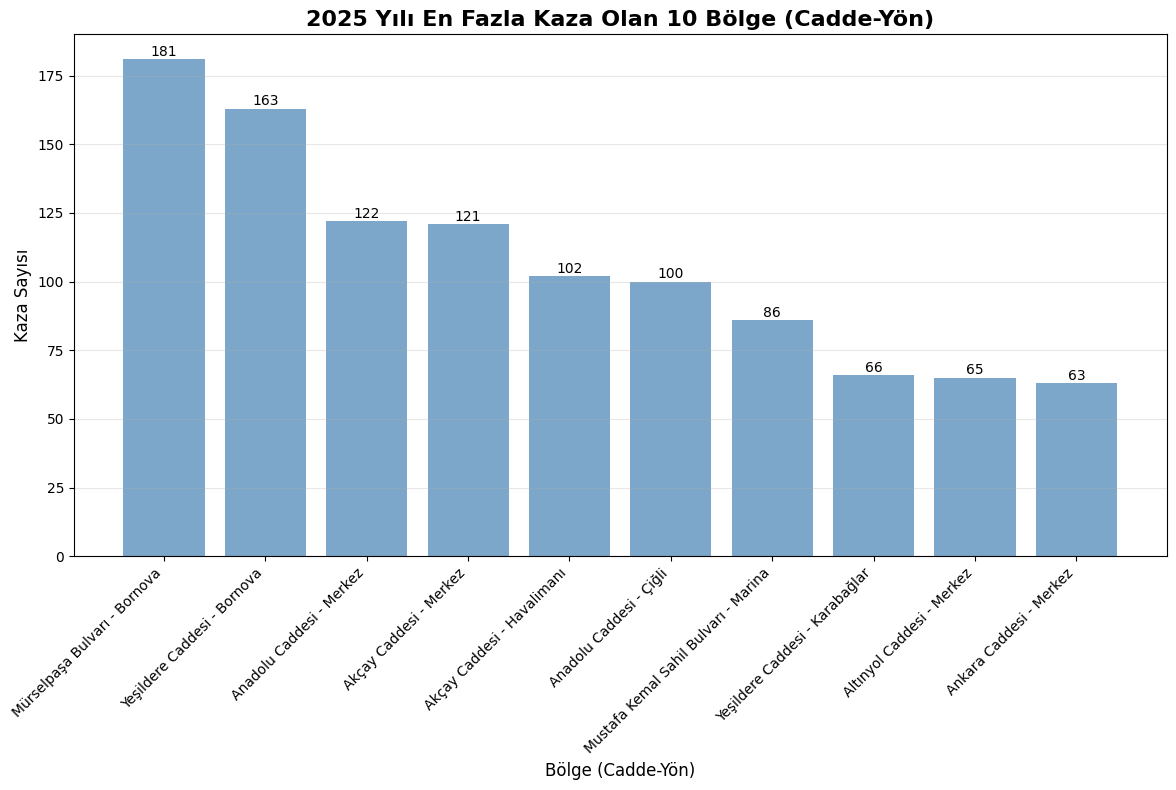


2025 yılı en fazla kaza olan 10 bölge:
Mürselpaşa Bulvarı - Bornova: 181 kaza
Yeşildere Caddesi - Bornova: 163 kaza
Anadolu Caddesi - Merkez: 122 kaza
Akçay Caddesi - Merkez: 121 kaza
Akçay Caddesi - Havalimanı: 102 kaza
Anadolu Caddesi - Çiğli: 100 kaza
Mustafa Kemal Sahil Bulvarı - Marina: 86 kaza
Yeşildere Caddesi - Karabağlar: 66 kaza
Altınyol Caddesi - Merkez: 65 kaza
Ankara Caddesi - Merkez: 63 kaza


In [52]:
# Plot top accident areas for 2025
plot_top_accident_areas_by_year(2025)


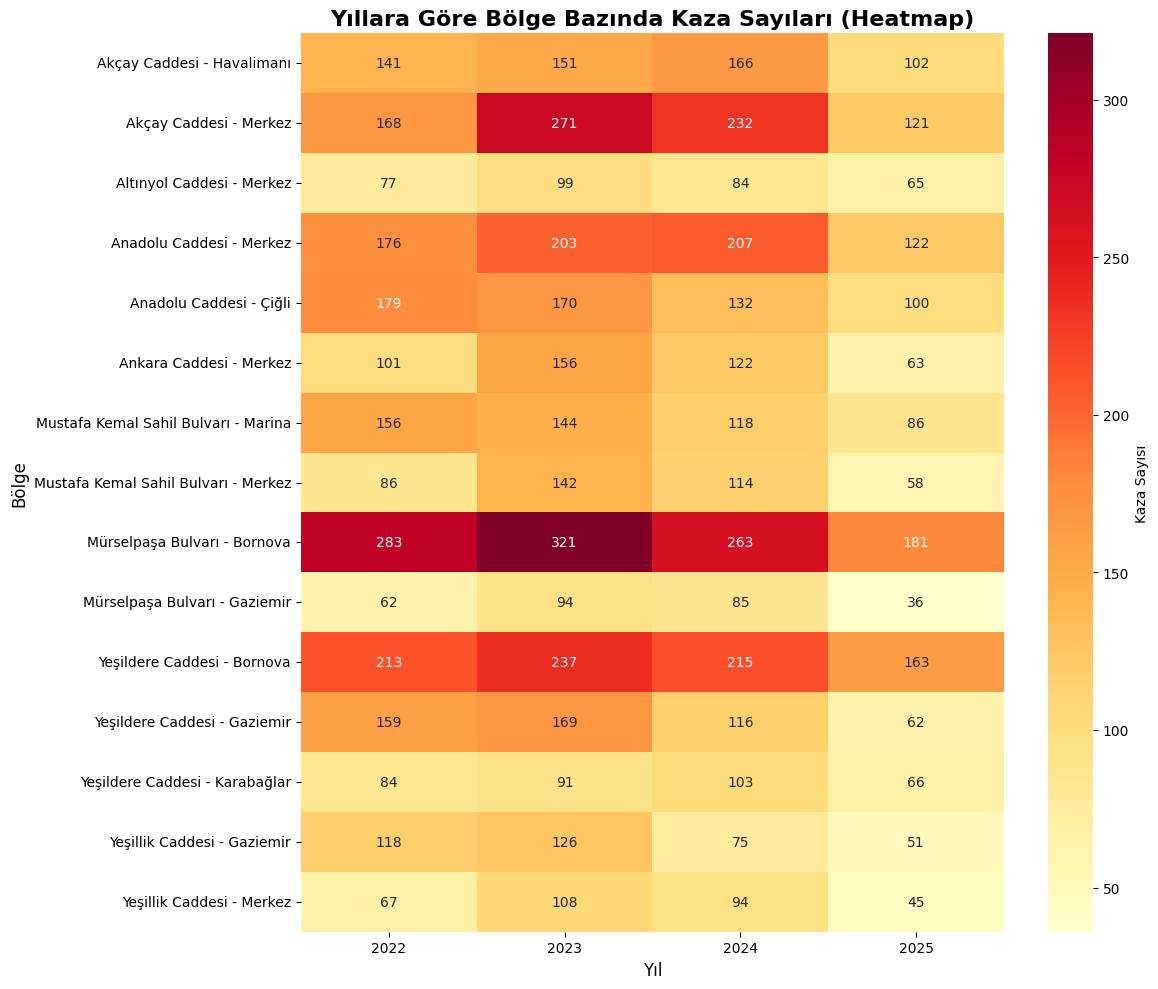

In [ ]:
def create_heatmap():
    pivot_data = df.groupby(['year', 'street', 'direction']).size().reset_index(name='count')
    pivot_data['street_direction'] = pivot_data['street'] + ' - ' + pivot_data['direction']
    
    top_areas = pivot_data.groupby('street_direction')['count'].sum().nlargest(15).index
    pivot_data = pivot_data[pivot_data['street_direction'].isin(top_areas)]
    
    heatmap_data = pivot_data.pivot(index='street_direction', columns='year', values='count').fillna(0)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
                cbar_kws={'label': 'Kaza Sayısı'})
    plt.title('Yıllara Göre Bölge Bazında Kaza Sayıları (Heatmap)', fontsize=16, fontweight='bold')
    plt.xlabel('Yıl', fontsize=12)
    plt.ylabel('Bölge', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

create_heatmap()
